In [2]:
import glob
import json
from datetime import datetime as dt

import pandas as pd
from tqdm.notebook import tqdm

In [3]:
files = glob.glob("./data/**/*.json", recursive=True)
dfs = []

for file in tqdm(files):
    year = 2022
    month = 10
    _, _, day, hour, minute = file.split("/")
    minute = minute[: -len(".json")]
    with open(file) as f:
        data = json.load(f)
        new_df = pd.json_normalize(data)
        new_df["datetime"] = dt(
            year=int(year),
            month=int(month),
            day=int(day),
            hour=int(hour),
            minute=int(minute),
        )

        new_df.station_id = new_df.station_id.astype("int16")
        new_df.num_bikes_available = new_df.num_bikes_available.astype("int8")
        new_df.num_bikes_disabled = new_df.num_bikes_disabled.astype("int8")
        new_df.num_docks_available = new_df.num_docks_available.astype("int8")
        new_df.num_docks_disabled = new_df.num_docks_disabled.astype("int8")
        new_df.is_installed = new_df.is_installed.astype(bool)
        new_df.is_renting = new_df.is_renting.astype(bool)
        new_df.is_returning = new_df.is_returning.astype(bool)

        dfs.append(new_df)

  0%|          | 0/11497 [00:00<?, ?it/s]

In [4]:
df = pd.concat(dfs)
df = df.drop_duplicates(subset=["station_id", "last_reported"])

In [5]:
import math


def humansize(nbytes: int) -> str:
    """Convert bytes to human readable format.

    Source: https://stackoverflow.com/a/14996816/4864169

    Parameters
    ----------
    nbytes : int
        Number of bytes.

    Returns
    -------
    str
        Message that indicates number of bytes in a human readable format.

    """
    suffixes = ["B", "KB", "MB", "GB", "TB", "PB"]

    if nbytes < 0:
        raise ValueError("Number of bytes should be greater than or equal to zero")

    exp: int = 0 if nbytes == 0 else math.floor(math.log(nbytes, 1024))
    n_units: float = nbytes / math.pow(1024, exp)
    bytes_str = f"{n_units:.2f}".rstrip("0").rstrip(".")
    return f"{bytes_str} {suffixes[exp]}"


humansize(df.memory_usage(deep=True, index=True).sum())

'165.64 MB'

In [6]:
df.describe()

,station_id,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported
count,821898.000000,821898.000000,821898.000000,821898.000000,821898.000000,8.218840e+05
mean,245.828126,7.252918,1.027412,9.595383,0.001472,1.664929e+09
std,149.594133,5.920881,1.305899,6.310656,0.038341,2.008031e+05
min,2.000000,0.000000,0.000000,0.000000,0.000000,1.664582e+09
25%,116.000000,2.000000,0.000000,4.000000,0.000000,1.664754e+09
50%,234.000000,6.000000,1.000000,9.000000,0.000000,1.664929e+09
75%,378.000000,11.000000,2.000000,14.000000,0.000000,1.665102e+09
max,498.000000,42.000000,14.000000,42.000000,1.000000,1.665276e+09


In [86]:
len(df)

821898

In [7]:
df.head()

,station_id,num_bikes_available,num_bikes_available_types,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,datetime
0,2,18,"{'mechanical': 18, 'ebike': 0}",2,0,0,1.665274e+09,False,IN_SERVICE,True,True,True,None,2022-10-09 00:10:00
1,3,2,"{'mechanical': 2, 'ebike': 0}",0,18,0,1.665274e+09,False,IN_SERVICE,True,True,True,None,2022-10-09 00:10:00
2,4,8,"{'mechanical': 8, 'ebike': 0}",0,12,0,1.665274e+09,False,IN_SERVICE,True,True,True,None,2022-10-09 00:10:00
3,5,34,"{'mechanical': 34, 'ebike': 0}",3,5,0,1.665274e+09,False,IN_SERVICE,True,True,True,None,2022-10-09 00:10:00
4,6,17,"{'mechanical': 17, 'ebike': 0}",0,3,0,1.665274e+09,False,IN_SERVICE,True,True,True,None,2022-10-09 00:10:00


In [8]:
last_status = df.drop_duplicates(subset=["station_id"], keep="last")
df = df[
    df.station_id.isin(
        last_status.loc[last_status.status == "IN_SERVICE", "station_id"].values
    )
]
len(df)

821884

In [12]:
df["last_reported"] = pd.to_datetime(df["last_reported"], unit = 's')

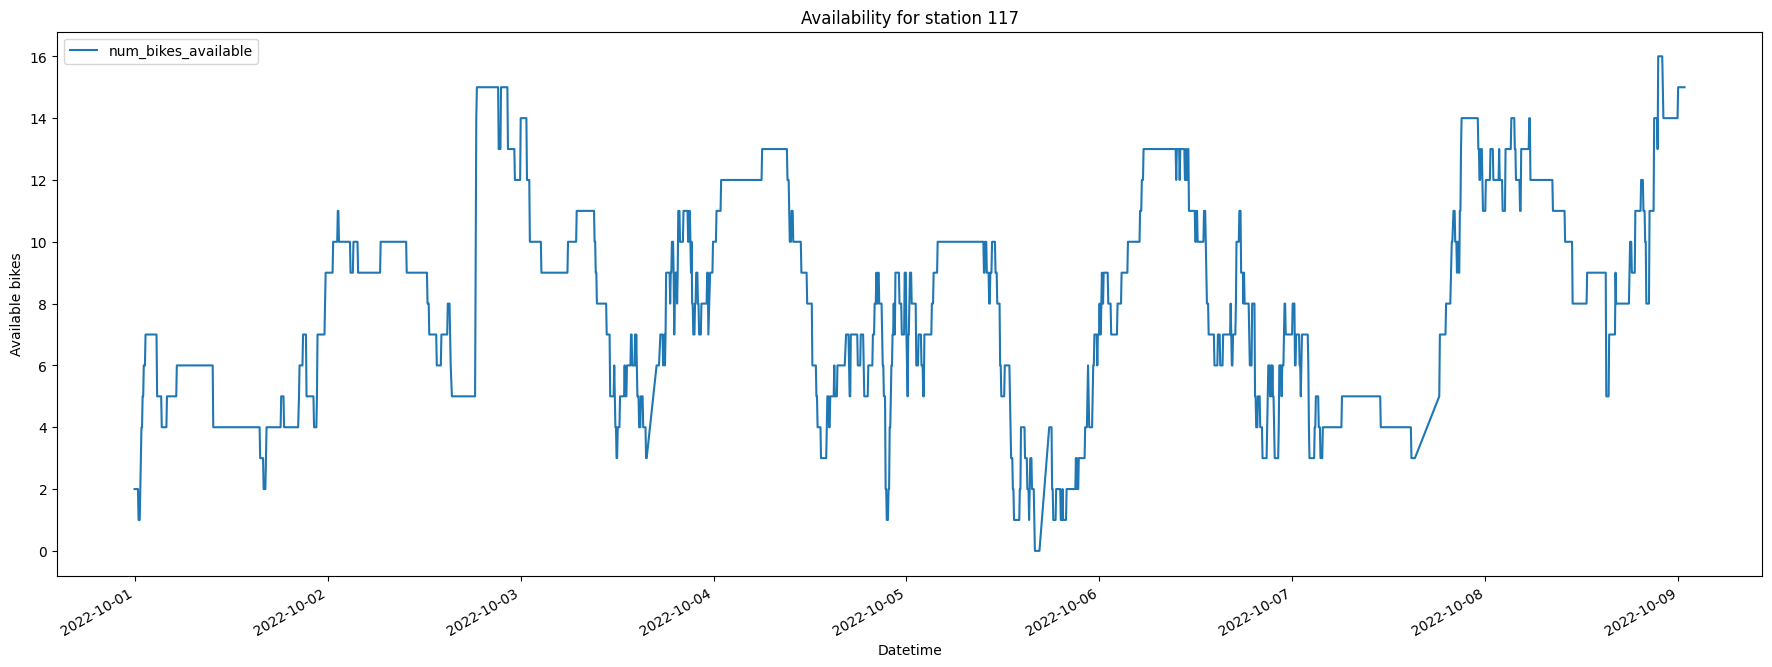

In [33]:
df.loc[df.station_id == 117].sort_values("last_reported").plot(
    y="num_bikes_available",
    x="last_reported",
    kind="line",
    figsize=(22, 8),
    title="Availability for station 117",
    ylabel="Available bikes",
    xlabel="Datetime",
);

In [28]:
df = df.sort_values(["station_id", "last_reported"])  # this way window functions are blazing fast
df["time_since_prev_report"] = df.groupby("station_id").last_reported.diff().dt.total_seconds()
df["available_bikes_delta"] = df.groupby("station_id").num_bikes_available.diff()

In [29]:
df.head()

,station_id,num_bikes_available,num_bikes_available_types,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,datetime,time_since_prev_report,available_bikes_delta
0,2,15,"{'mechanical': 15, 'ebike': 0}",5,0,0,2022-09-30 23:58:13,False,IN_SERVICE,True,True,True,None,2022-10-01 00:02:00,NaN,NaN
0,2,14,"{'mechanical': 14, 'ebike': 0}",5,1,0,2022-10-01 00:02:34,False,IN_SERVICE,True,True,True,None,2022-10-01 00:06:00,261.0,-1.0
0,2,14,"{'mechanical': 14, 'ebike': 0}",5,1,0,2022-10-01 00:06:53,False,IN_SERVICE,True,True,True,None,2022-10-01 00:10:00,259.0,0.0
0,2,14,"{'mechanical': 14, 'ebike': 0}",5,1,0,2022-10-01 00:11:14,False,IN_SERVICE,True,True,True,None,2022-10-01 00:11:00,261.0,0.0
0,2,14,"{'mechanical': 14, 'ebike': 0}",5,1,0,2022-10-01 00:15:34,False,IN_SERVICE,True,True,True,None,2022-10-01 00:17:00,260.0,0.0


In [35]:
df.to_parquet("./data/parquets/2022-10.parquet")